#  Code for 2D staggered Lagrangian method in Cartersian coordinates

## Control equations

一般形式下，弹塑性流体控制方程为：

质量方程：
\begin{equation}
  \frac{dm}{dt}=0
  \end{equation}
动量方程：
\begin{equation}
  \frac{d\rho \mathbf{u}}{dt}= \nabla \cdot  \mathbf{\Pi} 
\end{equation}

能量方程：
\begin{equation}
 \rho \frac{de}{dt}= \mathbf{\sigma} \cdot \mathbf{\varepsilon}
\end{equation}

\section{二维控制方程}

运动方程：
\begin{equation}
  \frac{d(r,z)}{dt}=(u,v)
\end{equation}

质量守恒：
\begin{equation}\label{eq:38}
  \frac{dm}{dt}=0
\end{equation}

动量守恒方程：
\begin{equation}\label{eq:3}
  \begin{array}{l}
	\displaystyle \rho \frac{du}{dt}=\frac{\partial \sigma _{rr}}{\partial r}+ \frac{\partial s_{rz}}{\partial z}\\[0.3cm]
  \displaystyle \rho \frac{dv}{dt}=\frac{\partial \sigma _{zz}}{\partial z}+ \frac{\partial s_{rz}}{\partial r}\\
  \end{array}
  \end{equation}

能量守恒方程：
\begin{equation}
  \begin{array}{l}
	\displaystyle \rho \frac{de}{dt}=\sigma _{rr}\frac{\partial u}{\partial r}+\sigma_{zz}\frac{\partial v}{\partial z}+s_{rz}\left( \frac{\partial u}{\partial z}+\frac{\partial v}{\partial r}\right)\\[0.3cm]
	\displaystyle = -p\frac{dV}{dt}+ s_{rr}\frac{\partial u}{\partial r}+s_{zz}\frac{\partial v}{\partial z}+s_{rz}\left( \frac{\partial u}{\partial z}+\frac{\partial v}{\partial r}\right)\\
	\end{array}
	\end{equation}

本构方程：
\begin{equation}
  \begin{array}{l}
	\displaystyle \frac{ds_{rr}}{dt}=2\mu \left(\frac{\partial u}{\partial r}-\frac{1}{3}\nabla \cdot \vec{u} \right) +s_{rz}\left(\frac{\partial u}{\partial z}-\frac{\partial v}{\partial r}\right)\\[0.3cm]
	\displaystyle \frac{ds_{zz}}{dt}=2\mu \left(\frac{\partial v}{\partial z}-\frac{1}{3}\nabla \cdot \vec{u} \right) -s_{rz}\left(\frac{\partial u}{\partial z}-\frac{\partial v}{\partial r}\right)\\[0.3cm]
	\displaystyle \frac{ds_{rz}}{dt}=\mu \left(\frac{\partial u}{\partial z}+\frac{\partial v}{\partial r}\right) + \frac{s_{rr}-s_{zz}}{2}\left(\frac{\partial u}{\partial z}-\frac{\partial v}{\partial r}\right)\\
  \end{array}
  \end{equation}

Von Mises屈服条件：
\begin{equation}
  \frac{3}{2}(s_{rr}^2+s_{zz}^2+s_{\theta \theta}^2+2s_{xy}^2)\le (Y^0)^2
\end{equation}







$$ s_{\theta\theta} = - (s_{rr} +s_{zz}) $$

## Compatible Staggered Discretization

<img src="Grid.png" width = "800" height = "400" div align=center /> 

<img src="cellpoint.png" width = "800" height = "400" div align=center />

### Quatities:

On point: ($x_p$,$y_p$), ($u_p$,$v_p$)

Zonal:  $V_z$, $\rho_z$, $m_z$, $e_z$, $p_z$

By the relation 
$$\frac{dm_z}{dt} =0$$
we have 
$$\rho_z(t) = m_z/V_z(t)$$

Also 
$$d(x_p)/dt = u_p, \quad d(y_p)/dt = v_p$$

In [211]:
struct Const
    Y0 ::Float64 #Yielding strength
    ρ0 ::Float64 
    Γ0 ::Float64
    μ  ::Float64
    a0 ::Float64
    s0 ::Float64
end


In [212]:
mutable struct Var
    r::Array{Float64,1}
    z::Array{Float64,1}
    u::Array{Float64,1}
    v::Array{Float64,1}
    ρ::Array{Float64,1}
    p::Array{Float64,1}
    s::Array{Float64,2} # σ[1] = σrr σ[2] = σzz σ[3] = σrz
end    

In [213]:
struct prb
    tt::Float64
    sf::Float64
end

### Point mass 

Point mass $m_p$ is used to solve point momentum $\mu_p = m_p \bf{u}_p$ and kinetic energy $K_p = m_p \frac{\bf{u}_p^2}{2}$

<img src="Ins.jpg" width = "200" height = "400" div align=center /> 

$$m_p = \sum_{z\in Z(p)} A_z^p \rho^p_z$$

$$\rho_z(t) = m_z/V_z(t)$$

In [214]:
function MassAndDens(mz::Array{Float64,1},x::Array{Float64,1},y::Array{Float64,1})
    
    Ic, = size(mz)
    Ip, = size(Tc)
    Asbz = zeros(Float64,4)
    ρ = zeros(Float64,Ic)
    mp = zeros(Float64,Ip)
    xz = zeros(Float64,4)
    yz = zeros(Float64,4)
    for i in 1:Ic
        xz[1:4] = x[Tp[i,1:4]]
        yz[1:4] = y[Tp[i,1:4]]
        Asbz = A_z(xz,yz)
        Az = sum(Asbz)
        ρ[i] = mz[i]/Az
        
        for j = 1:4
            ip = Tp[i,j]
            mp[ip] = mp[ip] + Asbz[j]*ρ[i]
        end
    end
   # @show mp
    return ρ,mp   
end

MassAndDens (generic function with 1 method)


$$ A_z^1 = \frac{5A_{41}+5A_{12}+A_{23}+A_{34}}{12}$$
$$ A_z^2 = \frac{A_{41}+5A_{12}+5A_{23}+A_{34}}{12}$$
$$ A_z^3 = \frac{A_{41}+A_{12}+5A_{23}+5A_{34}}{12}$$
$$ A_z^4 = \frac{5A_{41}+A_{12}+A_{23}+5A_{34}}{12}$$

In [215]:
function A_z(xz::Array{Float64,1},yz::Array{Float64,1}) 
    A =zeros(Float64,4)
    xc= sum(xz[i] for i in 1:4)/4
    yc= sum(yz[i] for i in 1:4)/4
    
    A41 = Area3(xz[4],xz[1],xc,yz[4],yz[1],yc)
    A12 = Area3(xz[1],xz[2],xc,yz[1],yz[2],yc)
    A23 = Area3(xz[2],xz[3],xc,yz[2],yz[3],yc)
    A34 = Area3(xz[3],xz[4],xc,yz[3],yz[4],yc)

    A[1] = (5A41+5A12+A23+A34)/12
    A[2] = (A41+5A12+5A23+A34)/12
    A[3] = (A41+A12+5A23+5A34)/12
    A[4] = (5A41+A12+A23+5A34)/12
    
#    A[1] = (A41+A12+A23+A34)/4
#    A[2] = (A41+A12+A23+A34)/4
#    A[3] = (A41+A12+A23+A34)/4
#    A[4] = (A41+A12+A23+A34)/4
    
    return A
end

A_z (generic function with 1 method)

<img src="n12.png" width = "300" height = "300" div align=center />

$$\overrightarrow{n}_{12} = \frac{1}{L_{12}}(y_2- y_1, x_1-x_2)  $$

$$\overrightarrow{\tau}_{12} = \frac{1}{L_{12}}(x_2- x_1, y_2-y_1)  $$

$$ \mathbf{F_1}  = \frac{1}{2}  \left[ -\sigma_{rr}(z_2-z_4)+ s_{rz}(r_2 -r_4), \sigma_{zz}(r_2-r_4) +s_{rz}(z_4 -z_2) , \right] $$ 

In [216]:
function force_zone(x,y,u,v,ρ,p,σ) #(r,z)
   
    Fx = zeros(Float64,4)
    Fy = zeros(Float64,4)
    
    
    Fx[1] = 0.5(σ[1]*(y[4] - y[2]) + σ[3]*(x[2] - x[4]))
    Fy[1] = 0.5(σ[3]*(y[4] - y[2]) + σ[2]*(x[2] - x[4]))
    
    Fx[2] = 0.5(σ[1]*(y[1] - y[3]) + σ[3]*(x[3] - x[1]))
    Fy[2] = 0.5(σ[3]*(y[1] - y[3]) + σ[2]*(x[3] - x[1]))
    
    Fx[3] = 0.5(σ[1]*(y[2] - y[4]) + σ[3]*(x[4] - x[2]))
    Fy[3] = 0.5(σ[3]*(y[2] - y[4]) + σ[2]*(x[4] - x[2]))
    
    Fx[4] = 0.5(σ[1]*(y[3] - y[1]) + σ[3]*(x[1] - x[3]))
    Fy[4] = 0.5(σ[3]*(y[3] - y[1]) + σ[2]*(x[1] - x[3]))
      
    ex,ey = hourglass_viscosity(x, y, u, v, ρ, p,σ) 

    Fx = Fx .+ ex
    Fy = Fy .+ ey
    
    return Fx,Fy
end           

force_zone (generic function with 1 method)

\begin{equation}
  \begin{aligned}
	&\displaystyle \rho \frac{de}{dt}= \mathbf{\sigma} \cdot \mathbf{\varepsilon}\\ 
	&=
	\sigma _{rr}\frac{\partial u}{\partial r}+\sigma_{zz}\frac{\partial v}{\partial z}+\sigma_{rz}\left( \frac{\partial u}{\partial z}+\frac{\partial v}{\partial r}\right)
	\end{aligned}
	\end{equation}
    
\begin{equation}
  \begin{aligned}
	&\displaystyle M \frac{de}{dt}=  
\int_{\Omega} \sigma _{rr}\frac{\partial u}{\partial r}+\sigma_{zz}\frac{\partial v}{\partial z}+\sigma_{rz}\left( \frac{\partial u}{\partial z}+\frac{\partial v}{\partial r}\right)d\Omega
	\end{aligned}
	\end{equation}


\begin{equation}
  \begin{aligned}
\int_{\Omega}  \frac{\partial u}{\partial r} d\Omega&=  -\oint_{\partial \omega}u dz\\
  &= \frac{1}{2} \left((u_1-u_3)(z_2-z_4)+(u_2-u_4)(z_3-z_1)\right)
  \end{aligned}
\end{equation}

\begin{equation}
  \begin{aligned}
\int_{\Omega}  \frac{\partial u}{\partial z} d\Omega&= \oint_{\partial \omega}u dy\\
  &= -\frac{1}{2} \left((u_1-u_3)(r_2-r_4)+(u_2-u_4)(r_3-r_1)\right)
  \end{aligned}
\end{equation}

$$ \frac{\partial u}{\partial x}  \approx \frac{1}{2A}((u_1-u_3)(y_2-y_4)+(u_2-u_4)(-y_1+y_3))$$ 

$$ \frac{\partial v}{\partial y}  \approx -\frac{1}{2A}((v_1-v_3)(x_2-x_4)+(v_2-v_4)(-x_1+x_3))$$ 

对于节点
$$ \rho \frac{d \mathbf{u}}{dt} = - \nabla p$$

$$m_p \frac{d\bf{u}_p}{dt} = \sum_{p\in P(z)} \bf{F}_z^p$$

$$F_z^1 = \mathbf{F}_1 + c\mathbf{e}_1$$

本构方程：
\begin{equation}
  \begin{array}{l}
	\displaystyle \frac{ds_{rr}}{dt}=2\mu \left(\frac{\partial u}{\partial r}-\frac{1}{3}\nabla \cdot \vec{u} \right) +s_{rz}\left(\frac{\partial u}{\partial z}-\frac{\partial v}{\partial r}\right)\\[0.3cm]
	\displaystyle \frac{ds_{zz}}{dt}=2\mu \left(\frac{\partial v}{\partial z}-\frac{1}{3}\nabla \cdot \vec{u} \right) -s_{rz}\left(\frac{\partial u}{\partial z}-\frac{\partial v}{\partial r}\right)\\[0.3cm]
	\displaystyle \frac{ds_{rz}}{dt}=\mu \left(\frac{\partial u}{\partial z}+\frac{\partial v}{\partial r}\right) - \frac{s_{rr}-s_{zz}}{2}\left(\frac{\partial u}{\partial z}-\frac{\partial v}{\partial r}\right)\\
  \end{array}
  \end{equation}

Von Mises屈服条件：
\begin{equation}
  \frac{3}{2}(s_{rr}^2+s_{zz}^2+s_{\theta \theta}^2+2s_{xy}^2)\le (Y^0)^2
\end{equation}


In [383]:
function rhs(var::Var)
    μ = con1.μ
    r,z,u,v,ρ,p,s = var.r,var.z,var.u,var.v,var.ρ,var.p,var.s
    
    Ic, = size(Tp)
    Ip, = size(Tc)
    rhsu = zeros(Float64,Ip)
    rhsv = zeros(Float64,Ip) 
    rhse = zeros(Float64,Ic)
    rhss = zeros(Float64,Ic,3)
    σ = zeros(Float64,Ic,3)
    Fys = zeros(Float64,Ic,2)
    
    σ[:,1] = s[:,1] - p[:]
    σ[:,2] = s[:,2] - p[:]
    σ[:,3] = s[:,3] 
    
    rcell = zeros(Float64,4)
    zcell = zeros(Float64,4)
    ucell = zeros(Float64,4)
    vcell = zeros(Float64,4)
    
    for i in 1:Ic
        for j =1:4
            rcell[j] = r[Tp[i,j]]
            zcell[j] = z[Tp[i,j]]
            ucell[j] = u[Tp[i,j]]
            vcell[j] = v[Tp[i,j]]
        end
        Az = sum(A_z(rcell,zcell))
        Fx,Fy = force_zone(rcell,zcell,ucell,vcell,ρ[i],p[i],σ[i,1:3])  
        Fys[i,1:2] .= rcell[2] -rcell[4],rcell[3] -rcell[1]
        ∂u_∂r,∂u_∂z = ∂uv(rcell,zcell, ucell)
        ∂v_∂r,∂v_∂z = ∂uv(rcell,zcell, vcell)
        rhse[i] = σ[i,1]*∂u_∂r + σ[i,2]*∂v_∂z+σ[i,3]*(∂u_∂z + ∂v_∂r)
        for j = 1:4
            ip = Tp[i,j]
            rhsu[ip] +=  Fx[j]
            rhsv[ip] +=  Fy[j]
        end  
        ∇u = ∂u_∂r + ∂v_∂z
    
        rhss[i,1] =  (2μ*(2/3*∂u_∂r - 1/3*∂v_∂z) + σ[i,3]*(∂u_∂z - ∂v_∂r)) ./Az
        rhss[i,2] =  (2μ*(2/3*∂v_∂z - 1/3*∂u_∂r) - σ[i,3]*(∂u_∂z - ∂v_∂r)) ./Az
        rhss[i,3] =   (μ*(∂u_∂z+∂v_∂r)  -   (σ[i,1] - σ[i,2])*(∂u_∂z - ∂v_∂r)) ./Az     
    #    @show rhsu 
    end

    output(Fys)
    return rhse, rhsu,rhsv,rhss

end     

rhs (generic function with 1 method)

In [376]:
function output(f)
    io = open("data2.dat", "w+")
     writedlm(io,f,"  ") 
    close(io)
end

output (generic function with 1 method)

$$ \mathbf{S} = \mathbf{S} \times \text{min} \left(1,Y_0/\sqrt{\frac{3}{2}\mathbf{S}:\mathbf{S}}\right)$$

In [218]:
function yield_s!(s,con)
    Y0 = con.Y0
    I, = size(s)
    for i in 1:I
         sums = s[i,1]^2 +s[i,2]^2 +2*s[i,3]^2 +(s[i,1]+s[i,2])^2
        for j = 1:3
       
        s[i,j] = s[i,j] * min(1,Y0/√(3/2*sums))
            end 
    end
    return s
end

yield_s! (generic function with 1 method)

In [488]:
function predictor_corrector2nd(dt,var::Var,mz)
    r,z,u,v,ρ,p,s = var.r,var.z,var.u,var.v,var.ρ,var.p,var.s
    
    Ip, = size(u)
    Ic, = size(p)
    
    ρ,mp = MassAndDens(mz,r,z)
    e = p_to_e(ρ, p,con1)    
    p = artificial_viscosity!(r,z,u,v,ρ,p)
    ρ,p,s = bound_ghost_cell!(ρ,p,s)
    var = Var(r, z, u, v, ρ, p, s)
    
    rhse, rhsu,rhsv,rhss = rhs(var)
    rhsu,rhsv = bound_force(rhsu,rhsv,var)
    
    s = yield_s!(s,con1)
    r₀ =  r + dt*u
    z₀  = z + dt*v
    u₀  = u + dt*(rhsu ./ mp)
    v₀  = v + dt*(rhsv ./ mp)
    e₀  = e + dt*(rhse ./ mz) 
    s₀  = s + dt*rhss
  #  @show rhsu
    s₀ = yield_s!(s₀,con1)
    r₀,z₀ = bound_ghost_coordinate!(r₀,z₀)
    ρ,mp = MassAndDens(mz,r₀,z₀)
    p = e_to_p(ρ,e₀,con1)
    p = artificial_viscosity!(r₀,z₀,u₀,v₀,ρ,p) 
    ρ,p,s₀ = bound_ghost_cell!(ρ,p,s₀)
    var = Var(r₀, z₀, u₀, v₀, ρ, p, s₀)
   
    rhse₀,rhsu₀,rhsv₀,rhss₀ = rhs(var)
    rhsu₀,rhsv₀ = bound_force(rhsu₀,rhsv₀,var)
  #  @show s[:,1]
    r +=  0.5dt*(u + u₀)
    z +=  0.5dt*(v + v₀)
    u +=  0.5dt*(rhsu + rhsu₀) ./ mp
    v +=  0.5dt*(rhsv + rhsv₀) ./ mp
    e +=  0.5dt*(rhse + rhse₀) ./ mz
    s  += 0.5dt*(rhss + rhss₀)
    s = yield_s!(s,con1)
    r,z = bound_ghost_coordinate!(r,z)
    ρ,mp = MassAndDens(mz,r,z)
    p = e_to_p(ρ,e,con1)
    ρ,p,s = bound_ghost_cell!(ρ,p,s)
    var = Var(r,z,u,v,ρ,p,s)
   
    return var
end

predictor_corrector2nd (generic function with 1 method)

In [220]:
function fη(ρ,c::Const)
    η = ρ/c.ρ0
    fη=(η .-1.0) .* (η .-c.Γ0*(η .-1.0)/2.0) ./ (η .-c.s0*(η .-1)) .^2
end

function fηη(ρ,c::Const)
    η = ρ/c.ρ0
    fηη=(η .+(c.s0-c.Γ0) .* (η .-1)) ./(η .-c.s0*(η .- 1)) .^3
end

fηη (generic function with 1 method)

In [356]:
function euler1st(dt,var::Var,mz)
    r,z,u,v,ρ,p,s = var.r,var.z,var.u,var.v,var.ρ,var.p,var.s
    
    Ip, = size(u)
    Ic, = size(p)
    
    ρ,mp = MassAndDens(mz,r,z)
    e = p_to_e(ρ, p,con1)    
    p = artificial_viscosity!(r,z,u,v,ρ,p)
    ρ,p,s = bound_ghost_cell!(ρ,p,s)
    var = Var(r, z, u, v, ρ, p, s)
    
    rhse, rhsu,rhsv,rhss = rhs(var)
    rhsu,rhsv = bound_force(rhsu,rhsv,var)
    
 #   @show rhsv
    s = yield_s!(s,con1)
    r =  r + dt*u
    z = z + dt*v
    u  = u + dt*(rhsu ./ mp)
    v  = v + dt*(rhsv ./ mp)
    e  = e + dt*(rhse ./ mz) 
    s  = s + dt*rhss
  #  @show rhsu
    s = yield_s!(s,con1)
    r,z,u,v = bound_ghost_coordinate!(r,z,u,v)
    ρ,mp = MassAndDens(mz,r,z)
    p = e_to_p(ρ,e,con1)
    ρ,p,s = bound_ghost_cell!(ρ,p,s)
    var = Var(r,z,u,v,ρ,p,s)
   
    return var
end

euler1st (generic function with 1 method)

### Boundary force

If one edge of a cell is a free boundary, then $f$ on the points is zero. As we have add it in RHs(), we need to remove it by resolve it again. Different from RHs(), at every point of a cell the force is composited by two parts on different edges. This is distinguished by $k$ when $k = 1$ the boundary is on y direction, forces on 12 and 34 boundary must be subtracted. When $ k =2$ the boundary is on x direction, subtract forces on 41, 23. 

In [498]:
function bound_force(rhsu,rhsv,var)
    Ip, = size(Tc)
    Ib, = size(Tb)
   
    r,z,u,v,ρ,p,s = var.r,var.z,var.u,var.v,var.ρ,var.p,var.s
    rcell = zeros(Float64,4)
    zcell = zeros(Float64,4)
    ucell = zeros(Float64,4)
    vcell = zeros(Float64,4)
    ip1 = zeros(Int,4)
    σ = zeros(Float64,3)
    for i in 1:Ib
        if Tb[i,4] == 1 || Tb[i,4] == 3
            ic = Tb[i,1]        
            rcell[1:4] = r[Tp[ic,1:4]]
            zcell[1:4] = z[Tp[ic,1:4]]
            ucell[1:4] = u[Tp[ic,1:4]]
            vcell[1:4] = v[Tp[ic,1:4]]

            σ[1] = s[ic,1] - p[ic]
            σ[2] = s[ic,2] - p[ic]
            σ[3] = s[ic,3]

            ex,ey = hourglass_viscosity(rcell, zcell, ucell, vcell, ρ[ic]
                                        , p[ic],s[ic,:])
            i₁ = Tb[i,3]
            i₂ = i₁+1
            if i₁ == 4
                i₂ = 1
            end
            nx = zcell[i₂] -zcell[i₁]
            ny = rcell[i₁] -rcell[i₂]
            p0 = 0.0
            for j in (i₁,i₂)

                ip = Tp[ic,j]
                    Fx = -σ[1]*nx/2 -σ[3]*ny/2+ex[j] #*nx^2/(nx^2+ny^2)  #+ex[j] 
                    Fy = -σ[3]*nx/2 -σ[2]*ny/2+ey[j] #*ny^2/(nx^2+ny^2)
                  #  Fx1 = (Fx*nx+Fy*ny)*nx/(nx^2+ny^2)
                 #   Fy1 = (Fx*nx+Fy*ny)*ny/(nx^2+ny^2)
                 #   Fx = Fx- Fx1
                  #  Fy = Fy - Fy1
                    Fx1 =  p0*nx/2 #+ex[j]*nx^2/(nx^2+ny^2) 
                    Fy1 =  p0*ny/2 #+ey[j]*ny^2/(nx^2+ny^2)

                    rhsu[ip] +=  -Fx -Fx1
                    rhsv[ip] +=  -Fy -Fy1

                if Tb[i,4] == 3 # boundary
                    uL = 2e-3
                    u[ip] = uL #*nx/(nx^2 +ny^2)
                end  
            end
        end
    end 

    return rhsu, rhsv
end  

bound_force (generic function with 1 method)

<img src="bound_corresponding.png" width = "400" height = "800" div align=center /> 

$$ Ig_1 = Tb[i,3] $$
$$Ib_1 = Ig_1 -1$$

In [460]:
function bound_ghost_coordinate!(r,z)
    Ip, = size(Tc)
    Ic, = size(Tp)
    Ib, = size(Tb)
   # r,z,u,v,ρ,p,s = var.r,var.z,var.u,var.v,var.ρ,var.p,var.s
   
    rt= deepcopy(r)
    zt= deepcopy(z)
   # output(r)
    for i in 1:Ib
        if Tb[i,4] == 2
            ic = Tb[i,1]
            ic2= Tb[i,2]
            ig₁ = Tb[i,3]


            ig₁ == 4 ? ig₂ = 1 : ig₂ = ig₁+1
            ig₂ == 4 ? ig₃ = 1 : ig₃ = ig₂+1
            ig₃ == 4 ? ig₄ = 1 : ig₄ = ig₃+1

            ig₁ == 1 ? ib₁ = 4 : ib₁ = ig₁-1
            ib₁ == 1 ? ib₂ = 4 : ib₂ = ib₁-1
            ib₂ == 1 ? ib₃ = 4 : ib₃ = ib₂-1
            ib₃ == 1 ? ib₄ = 4 : ib₄ = ib₃-1

                r1 =    rt[Tp[ic2,ib₁]]
                r2 =    rt[Tp[ic2,ib₂]]
                z1 =    zt[Tp[ic2,ib₁]]
                z2 =    zt[Tp[ic2,ib₂]]

                r3=     rt[Tp[ic2,ib₃]]
                z3=     zt[Tp[ic2,ib₃]]
                r4=     rt[Tp[ic2,ib₄]]
                z4=     zt[Tp[ic2,ib₄]]
                
            
                r[Tp[ic,ig₃]],z[Tp[ic,ig₃]] = reflect(r1,z1,r2,z2,r3,z3)
                r[Tp[ic,ig₄]],z[Tp[ic,ig₄]] = reflect(r1,z1,r2,z2,r4,z4)
       
          end 
    end
    return r,z
end  

bound_ghost_coordinate! (generic function with 2 methods)

In [458]:
A= [2,3,5]
B = copy(A)
B[2] = 4
A

3-element Array{Int64,1}:
 2
 3
 5

In [261]:
function bound_ghost_cell!(ρ,p,s)
    Ip, = size(Tc)
    Ic, = size(Tp)
    Ib, = size(Tb)    
    for i in 1:Ib
        if Tb[i,4] == 2
            ic = Tb[i,1]
            ic2= Tb[i,2]
            ρ[ic] = ρ[ic2]
            p[ic] = p[ic2]
            s[ic,1:2] = s[ic2,1:2]
            s[ic,3] = -s[ic2,3]
          end 
    end
    return ρ,p,s
end  

bound_ghost_cell! (generic function with 1 method)

In [225]:
exp1[r4]

(r₁ - r₂)⋅(r₁⋅r₃ - r₂⋅r₃ + z₁⋅z₃ - z₂⋅z₃) - (z₁ - z₂)⋅(2⋅r₁⋅z₂ - r₁⋅z₃ - 2⋅r₂⋅
──────────────────────────────────────────────────────────────────────────────
                                                  2            2              
                                         (r₁ - r₂)  + (z₁ - z₂)               

z₁ + r₂⋅z₃ + r₃⋅z₁ - r₃⋅z₂)
───────────────────────────
                           
                           

## Ghost cell coordinate of a reflect boundary

<img src="reflect.png" width = "200" height = "400" div align=center /> 

$$ k_1 k_2 = -1$$
$$ d_3 = -d_4 $$

$$(z_2-z_1)(z_3-z_4)+(r_3-r_4)(r_2-r_1) = 0$$
$$(z_2-z_1)(r_3-r_1)-(z_3-z_1)(r_2-r_1) = -(z_2-z_1)(r_4-r_1)+(z_4-z_1)(r_2-r_1)$$

In [226]:
using SymPy
@vars z1 z2 z3 z4 r1 r2 r3 r4
exp1 = solve([(z2-z1)*(z3-z4)+(r2-r1)*(r3-r4),(z2-z1)*(r3-r1)-(z3-z1)*(r2-r1)+(z2-z1)*(r4-r1)-(z4-z1)*(r2-r1)],[r4,z4])
@show exp1[r4],exp1[z4]

(exp1[r4], exp1[z4]) = (((r1 - r2)*(r1*r3 - r2*r3 + z1*z3 - z2*z3) - (z1 - z2)*(2*r1*z2 - r1*z3 - 2*r2*z1 + r2*z3 + r3*z1 - r3*z2))/((r1 - r2)^2 + (z1 - z2)^2), ((r1 - r2)*(2*r1*z2 - r1*z3 - 2*r2*z1 + r2*z3 + r3*z1 - r3*z2) + (z1 - z2)*(r1*r3 - r2*r3 + z1*z3 - z2*z3))/((r1 - r2)^2 + (z1 - z2)^2))


(((r1 - r2)*(r1*r3 - r2*r3 + z1*z3 - z2*z3) - (z1 - z2)*(2*r1*z2 - r1*z3 - 2*r2*z1 + r2*z3 + r3*z1 - r3*z2))/((r1 - r2)^2 + (z1 - z2)^2), ((r1 - r2)*(2*r1*z2 - r1*z3 - 2*r2*z1 + r2*z3 + r3*z1 - r3*z2) + (z1 - z2)*(r1*r3 - r2*r3 + z1*z3 - z2*z3))/((r1 - r2)^2 + (z1 - z2)^2))

In [227]:
function reflect(r1,z1,r2,z2,r3,z3)
    tmp1=(r1*r3-r2*r3+z1*z3-z2*z3) 
    tmp2 = (2r1*z2-r1*z3-2r2*z1+r2*z3+r3*z1-r3*z2)
    tmp3 = ((r1-r2)^2+(z1-z2)^2)
    
    r4 = ((r1-r2)*tmp1 - (z1-z2)*tmp2)/tmp3
    z4 = ((r1-r2)*tmp2 + (z1-z2)*tmp1)/tmp3
    
    return r4,z4
end

reflect (generic function with 1 method)

In [228]:
reflect(1,1,1,0,0.9,0)

(1.1, 0.0)

### EOS 
$$ e = \frac{p}{(\gamma-1)\rho}$$

In [229]:
function p_to_e(ρ,p,con)
    c=con
    ei = (p .- c.ρ0*c.a0^2*fη(ρ,c))/(c.ρ0*c.Γ0)
    return ei
end
function e_to_p(ρ,ei,con::Const)
    c=con
    p = c.ρ0*c.Γ0*ei .+ c.ρ0*c.a0^2*fη(ρ,c)
    return p
end

e_to_p (generic function with 1 method)

In [230]:
function CFL(SF,var)
    r,z,u,v,ρ,p,s = var.r,var.z,var.u,var.v,var.ρ,var.p,var.s
    Ic, = size(ρ)
    cflmin = 1.e9
      cfl = 0 
    for i in 1:Ic
        cfl =0
        u2max = 0
        u2=0.0
        for j = 1:4
            ip = Tp[i,j]
            u2 = u[ip]^2+v[ip]^2
            if u2 > u2max ; u2max = u2; end
        end
        
        dlmin = (r[Tp[i,4]] - r[Tp[i,1]])^2+(z[Tp[i,4]]-z[Tp[i,1]])^2
       
        for j=1:3
            dl= (r[Tp[i,j+1]] - r[Tp[i,j]])^2+(z[Tp[i,j+1]]-z[Tp[i,j]])^2
            if dl < dlmin; dlmin=dl; end
        end
        c = sound([ρ[i],u[i],p[i],min(s[i,1],s[i,2])],con1)
        cfl = √(dlmin)/(√(u2max)+c)
        if cfl < cflmin; cflmin = cfl; end
    end
 #   @show cflmin
    dt = cflmin*SF
    return dt
end 
        

CFL (generic function with 1 method)

In [231]:
function sound(uo::Array{Float64,1},con::Const,EoP::Int=1)
    a0,ρ0,Γ0,Y0,μ  = con.a0,con.ρ0,con.Γ0,con.Y0,con.μ
    ρ,uu,p,sxx   = uo[1:4]
    a2  = a0^2*fηη(ρ,con)+p/ρ^2*ρ0*Γ0
    if EoP == 2
        c=sqrt(a2-ρ0/ρ^2*Γ0*sxx)
        return c
    else
       #  @show a2,ρ0/ρ^2,4.0/3*μ/ρ
        c=sqrt(a2-ρ0/ρ^2*Γ0*sxx+4.0/3*μ/ρ)
       
        return c
    end
end

sound (generic function with 2 methods)

In [487]:
function TimeSolve(var,mz)
    tt= problem.tt
    sf =problem.sf
    t= 0.0
    t₁ = tt/100
    t₂ = t₁
    kinetic_init,energy = total_kinetic(var,mz)
    kinetic = kinetic_init
   # while kinetic > 1e-4*kinetic_init && t<tt
    while t<tt
    
#for i in 1:1
        dt=CFL(sf,var)
   #     @show dt
        if t+dt>tt
           dt = tt-t
        end
        
        var = predictor_corrector2nd(dt,var,mz)
       # var = euler1st(dt,var,mz)
     #   kinetic,energy = total_kinetic(var,mz)
         t += dt
        if t > t₁
            println(t)
            t₁ += t₂
      #      @show kinetic/kinetic_init,(energy+kinetic)/kinetic_init
        end
        
    end
    return var
end

TimeSolve (generic function with 1 method)

In [233]:
function total_kinetic(var,mz)
    r,z,u,v,ρ,p = var.r,var.z,var.u,var.v,var.ρ,var.p
    Ip, = size(Tc)
    Ic, = size(Tp)
    kinetic = 0
    energy = 0
     ρ1,mp = MassAndDens(mz, r, z)
    for i in 1:Ip
        kinetic += mp[i]*0.5*(u[i]^2+v[i]^2)
    end
    for i in 1:Ic
        energy += mz[i]*p_to_e(ρ[i], p[i], con1)
    end
    return kinetic,energy
end


total_kinetic (generic function with 1 method)

## Artificial Viscosity 

Use the strain rate to construct the artificial viscosity 
$$\frac{ds}{dt} = \frac{\partial u}{\partial x}  + \frac{\partial v}{\partial y} $$


Then the artificial viscosity can be written as
$$ q_w = \left\{ \begin{align}
\alpha L \rho \left( \frac{ds}{dt} \right)^2 +  \beta L^2 \rho c \left|\frac{ds}{dt}\right|, \quad \text{if}  \quad \frac{ds}{dt}< 0,\\
0, \quad \text{if} \quad \frac{ds}{dt}\ge 0. \\
\end{align}
\right.
$$
where $\alpha = 0.6$, $\beta = 2.0 $ and $c$ is the sonic speed.

$L$ is the reference length, and constructed as
$$L = A/L_{\text{max}} $$

$$L_{\text{max}} = \text{max}(L_{13},L_{24})$$


In [491]:
function artificial_viscosity_c!(x,y,u,v,ρ,p)
    xc = sum(x[i] for i in 1:4)/4
    yc = sum(y[i] for i in 1:4)/4
    
    ∂u_∂x,tmp = ∂uv(x,y,u)
    tmp,∂v_∂y = ∂uv(x,y,v)
    c = sound([ρ,0.0,p,0.0],con1)
    Lmax = max(√((x[3] - x[1])^2+(y[3] - y[1])^2) ,√((x[2] - x[4])^2+(y[2] - y[4])^2) )  
    A = area_quadrangle(x, y)
    L = A/Lmax 

    if ∂u_∂x + ∂v_∂y> 0
        q = 0
    else
        q = 0.6ρ*L*c*(abs(∂u_∂x+∂v_∂y))/A +2.0L^2*ρ*((∂u_∂x+∂v_∂y)^2)/A^2 
    end
    return p+q
end

artificial_viscosity_c! (generic function with 1 method)

$$b_2 \rho Lc \frac{\partial u}{\partial x} - b_{12}\rho L^2 \left(\frac{\partial u}{\partial x}\right)^2$$

In [235]:
function artificial_viscosity!(r,z,u,v,ρ,p)
    I, = size(Tp)
    rcell = zeros(Float64,4)
    zcell = zeros(Float64,4)
    ucell = zeros(Float64,4)
    vcell = zeros(Float64,4)
   
    for i in 1:I
        for j in 1:4
            ip = Tp[i,j]
            rcell[j] = r[ip]
            zcell[j] = z[ip]
            ucell[j] = u[ip]
            vcell[j] = v[ip]
        end
        p[i] = artificial_viscosity_c!(rcell,zcell,ucell,vcell,ρ[i],p[i])
    end
    
        return p
        
    end       

artificial_viscosity! (generic function with 1 method)

In [236]:
function l_viscosity(x,y,α)
    xc = sum(x)/4; yc = sum(y)/4
    d = zeros(Float64,4)
    for i in 1:4
    d[i] = distance(x[i],y[i],xc,yc,α)
    end
    A = A_z(x, y)
    L = 2sum(A)/sum(d)
    return L
end

l_viscosity (generic function with 1 method)

#### distance from  Point to line 
Line: $$ (xc -cos \alpha )(x-xc) = (yc-sin \alpha)(y-yc)$$
point: $x,y$

In [237]:
function distance(x,y,xc,yc,α)
    d = abs((xc - cosd(α)) * (x .-xc)- (yc-sind(α))*(y .- yc))/√((xc-cosd(α))^2+(yc-sind(α))^2)
    return d
end

distance (generic function with 1 method)

### 沙漏粘性 Hourglass

$$ \text{hg}_x = u_1 -u_2 + u_3 - u_4$$ 
$$ \text{hg}_x = v_1 -v_2 + v_3 - v_4$$ 

$$ e_{1x} = -\frac{1}{4}q\rho c\sqrt{A}\text{hg}_x $$
$$ e_{1y} = -\frac{1}{4}q\rho c\sqrt{A}\text{hg}_y $$

$$ e_{2x} = \frac{1}{4}q\rho c\sqrt{A}\text{hg}_x $$
$$ e_{2y} = \frac{1}{4}q\rho c\sqrt{A}\text{hg}_y $$

$$ e_{3x} = -\frac{1}{4}q\rho c\sqrt{A}\text{hg}_x $$
$$ e_{3y} = -\frac{1}{4}q\rho c\sqrt{A}\text{hg}_y $$

$$ e_{4x} = \frac{1}{4}q\rho c\sqrt{A}\text{hg}_x $$
$$ e_{4y} = \frac{1}{4}q\rho c\sqrt{A}\text{hg}_y $$

In [238]:
function hourglass_viscosity(x,y,u,v,ρ,p,s)
    hgx = u[1] - u[2] + u[3] -u[4]
    hgy = v[1] - v[2] + v[3] -v[4]
    
    ex =zeros(Float64,4)
    ey =zeros(Float64,4)
    A = area_quadrangle(x,y)
    c = sound([ρ,0.0,p,min(s[1],s[2])], con1)
 #   @show c
    q = 0.6 # coefficient of hourglass viscosity 0.01 - 0.5 ?
    ex[1] = -0.25q*ρ*c*√(A)*hgx
    ey[1] = -0.25q*ρ*c*√(A)*hgy
    
    ex[2] = -ex[1]
    ey[2] = -ey[1]
    
    ex[3] = ex[1]
    ey[3] = ey[1]
    
    ex[4] = ex[2]
    ey[4] = ey[2]
    
  ex .= 0
  ey .= 0
 #   @show ex,ey
    return ex, ey
end

hourglass_viscosity (generic function with 1 method)

In [239]:
function area_quadrangle(x::Array{Float64,1},y::Array{Float64,1}) 
   
    xc= sum(x[i] for i in 1:4)/4
    yc= sum(y[i] for i in 1:4)/4
    
    A41 = Area3(x[4],x[1],xc,y[4],y[1],yc)
    A12 = Area3(x[1],x[2],xc,y[1],y[2],yc)
    A23 = Area3(x[2],x[3],xc,y[2],y[3],yc)
    A34 = Area3(x[3],x[4],xc,y[3],y[4],yc)
    
    A = A12 + A23 +A34 +A41
    return A
end

area_quadrangle (generic function with 1 method)

In [240]:
function Area3(x1,x2,x3,y1,y2,y3)
    return abs((x1*y2+y1*x3+x2*y3-x1*y3-y1*x2-y2*x3)/2)
end

Area3 (generic function with 1 method)

###  $\frac{\partial (u,v)}{\partial (x,y)}$

we use the diffences between 1 and 3 points and 2 and 4 points to solve the partial differences approximately, as
$$ \frac{\partial u}{\partial x}  \approx \frac{1}{2A}((u_1-u_3)(y_2-y_4)+(u_2-u_4)(-y_1+y_3))$$ 

$$ \frac{\partial v}{\partial y}  \approx -\frac{1}{2A}((v_1-v_3)(x_2-x_4)+(v_2-v_4)(-x_1+x_3))$$ 
Similar process to $\frac{\partial u}{\partial y}$,$\frac{\partial v}{\partial x}$ and $\frac{\partial v}{\partial y}$

In [241]:
function ∂uv(x,y,u)
    ∂u_∂x = 0.5(u[1]-u[3])*(y[2]-y[4]) + 0.5(u[2]-u[4])*(y[3]-y[1])
    ∂u_∂y = -0.5(u[1]-u[3])*(x[2]-x[4]) - 0.5(u[2]-u[4])*(x[3]-x[1])
    return ∂u_∂x,∂u_∂y
end

∂uv (generic function with 1 method)

## Output function

In [242]:
function cell_coordinate(x,y)
    Ip, = size(Tc)
    Ic, = size(Tp)
    xc = zeros(Float64,Ic)
    yc = zeros(Float64,Ic)
    
    for i in 1:Ic
        for j = 1:4
            ip = Tp[i,j] 
            xc[i] += x[ip]/4
            yc[i] += y[ip]/4
        end
        
    end
    
    return xc,yc
end

cell_coordinate (generic function with 1 method)

In [243]:
function outputline(Ix,Iy,var,mz)
    r,z,u,v,ρ,p,s = var.r,var.z,var.u,var.v,var.ρ,var.p,var.s
    I, = size(ρ)
    
    uline =  zeros(Float64,Ix)
    rline =  zeros(Float64,Ix)
    zline =  zeros(Float64,Ix)
    ρline =  zeros(Float64,Ix)        
    pline =  zeros(Float64,Ix)  
    sline = zeros(Float64,Ix,3)
    for i in 1:Ix
        j = Int(floor(Iy/2))
            ip = i+(j-1 ) *(Ix+1)
            ic =i+(j-1)*Ix
            uline[i] = u[ip]
            rline[i]  = r[ip]
            ρline[i]  = ρ[ic]
            pline[i] = p[ic]
           # σline[i,:] .= σ[ic,:]
            sline[i,:] = s[ic,:]
    end
    return rline,uline,ρline,pline,sline
end

outputline (generic function with 1 method)

In [244]:
function Output_cell(Ix,Iy,var,mz)
    x,y,u,v,ρ,p,s= var.r,var.z,var.u,var.v,var.ρ,var.p,var.s
    Ip, = size(Tc)
    Ic, = size(Tp)
    io = open("data.dat", "w+")
    A = zeros(Float64,Ip,10)
    
    text = " TITLE = \"Dataset\"
VARIABLES = \"x\" \"y\" \"u\" \"v\" \"rho\" \"p\" \"srr\" \"szz\" \"szr\" \"s:s\"  ZONE T=\"Zone 1\" 
I=$Ix,J=$Iy,K=1,ZONETYPE=Ordered 
DATAPACKING=POINT \n "

    write(io,text) 
    for i in 1:Ic
        xc = 0
        yc =0
        uc =0
        vc =0
        for j = 1:4
            ip = Tp[i,j] 
                xc += x[ip]/4
                yc += y[ip]/4
                uc += u[ip]/4
                vc += v[ip]/4
        end
        
        A[i,1] = xc
        A[i,2] = yc
        A[i,3] = uc
        A[i,4] = vc
        A[i,5] = ρ[i]        
        A[i,6] = p[i]      
        A[i,7:9] .= s[i,1:3] 
        A[i,10] = (s[i,1]^2+s[i,2]^2 +2s[i,3]^2+(s[i,1]+s[i,2])^2)
    end
      writedlm(io, A, "  ")
    close(io)
end

Output_cell (generic function with 1 method)

In [297]:
function Output_point(Ix,Iy,var,mz)
    x,y,u,v,ρ,p,s = var.r,var.z,var.u,var.v,var.ρ,var.p,var.s
    Ip, = size(Tc)
    Ic, = size(Tp)
    
    io = open("data.dat", "w+")
    #s = zeros(Float64,Ip,3)
    A = zeros(Float64,Ip,9)
   # for i in 1:Ip
    
    text = " TITLE = \"Dataset\"
VARIABLES = \"x\" \"y\" \"u\" \"v\" \"rho\" \"p\" \"srr\" \"szz\" \"szr\"   ZONE T=\"Zone 1\" 
I=$(Ix+1),J=$(Iy+1),K=1,ZONETYPE=Ordered 
DATAPACKING=POINT \n "
  #  write(1,*)
    write(io,text)
    
       ρp = zeros(Float64,Ip)
       pp = zeros(Float64,Ip)
       np = zeros(Int,Ip)
       sp = zeros(Float64,Ip,3)
    
    for i in 1:Ic
        
        xc = 0
        yc =0
        uc =0
        vc =0
        for j = 1:4
            ip = Tp[i,j] 
            ρp[ip] += ρ[i]
            pp[ip] += p[i]
            sp[ip,:] += s[i,:]
            np[ip] += 1   
        end
    end
        ρp = ρp ./ np
        pp = pp ./ np
        sp = sp ./ np
    
        A[:,1] = x
        A[:,2] = y
        A[:,3] = u
        A[:,4] = v
        A[:,5] = ρp
        A[:,6] = pp
        A[:,7:9] .= sp[:,1:3]
    
      writedlm(io, A, "  ")
    close(io)
end

Output_point (generic function with 1 method)

## Cases

In [499]:
 function Piston()

    global problem = prb(1.5e2,0.1)
    # global problem = prb(3e-5,0.3)
     
    I = 200
    J = 5
    dx = 100/I
    dy = 10/J
    @show typeof(dx)
    I1= I+1
    J1= J+2
    global   con1 = Const(9e-5,8.930,2.0,4.5e-1,0.3940,1.49)
  #  global   con1 = Const(0.0,8930,2.0,4.5e10,3940.0,1.49)
    Ip = (I1+1)*(J1+1) # Number of  points
    Ic = I1*J1  # number of cells
    
    global Tp = zeros(Int,Ic,4) #格点
    global Tc = zeros(Int,Ip,4) #点格
    
    #@show Tc, Ip
    global Tb = zeros(Int, 2I1 + 2J1-2,4) #边界 
    
    ## Tb[i,1] ghost cell number
    ## Tb[i,2] bound cell number
    ## Tb[i,3] ghost cell point share with the bound 
    ## Tb[i,4] type of the boundary
    
    
    
   # 点格表，格点表初始化 
    for i in 1:I1 
        for j in 1:J1
            ic = i+(j-1)*I1
            Tp[ic,1] = i + (j-1)*(I1+1)
            Tp[ic,2] = i+1 +(j-1)*(I1+1)
            Tp[ic,3]=i+1+j*(I1+1)
            Tp[ic,4]=i+j*(I1+1) 
        end
    end
    
    for i = 1:I1+1
        for j = 1:J1+1
            ip =i+(j-1)*(I1+1)
            Tc[ip,1] = i +(j-1)*I1 #(i,j)
            Tc[ip,2] = i-1+(j-1)*I1 #(i-1,j)
            Tc[ip,3] = i-1+(j-2)*I1 #(i-1,j-1)
            Tc[ip,4] = i+(j-2)*I1   #(i,j-1)
        end
    end
    

# Bound 
  ib = 0
        for j = 1:J1
            i=1
            ib += 1
            ic =i+(j-1)*I1 
            Tb[ib,1] = ic
            Tb[ib,2] = (i+1)+(j-1)*I1
            Tb[ib,3] = 4
            Tb[ib,4] = 3
        end
    
      for i = 1:I1-1
            for j in (1,J1)
                ib += 1
                ic =i+(j-1)*I1
                
                Tb[ib,1] = ic
               
                if j==1 
                    Tb[ib,2] = i+(j+1-1)*I1
                    Tb[ib,3] = 3
                    Tb[ib,4] = 2
                end
                if j==J1
                    Tb[ib,2] = i+(j-1-1)*I1
                    Tb[ib,3] = 1
                    Tb[ib,4] = 2
                end
            end
        end
         for j = 1:J1
             i = I1
            ib += 1
            ic =i+(j-1)*I1
            Tb[ib,1] = ic
             Tb[ib,2] = (i-1)+(j-1)*I1 #bound type 1:free 2: wall ..  Tb[:,2] y direction
             Tb[ib,3] = 4
             Tb[ib,4] = 2
         end
    #流场初始化 Init of the flow
    
    x = zeros(Float64,Ip)
    y = zeros(Float64,Ip)
    u = zeros(Float64,Ip)
    v = zeros(Float64,Ip)
    
    ρ = zeros(Float64,Ic)
    mz = zeros(Float64,Ic)
    p = zeros(Float64,Ic)
    Az= zeros(Float64,Ic)
    s = zeros(Float64,Ic,3)
    
    for i in 1:I1+1
        for j = 1:J1+1
            ip =i+(j-1)*(I1+1)
            x[ip] = (i-1)*dx
            y[ip] = (j-2)*dy
            u[ip] = 0
            v[ip] = 0.0
        end
    end
    
      
    
    var = Var(x,y,u,v,ρ,p,s)
    x,y = bound_ghost_coordinate!(x,y)
    x,y = bound_ghost_coordinate!(x,y)
    xz = zeros(Float64,4)
    yz = zeros(Float64,4) 
    for i in 1:I1
        for j in 1:J1
            ic = i+(j-1)*(I1)
            xz[1:4] = x[Tp[ic,1:4]]
            yz[1:4] = y[Tp[ic,1:4]]
            A = A_z(xz,yz)
            Az[ic] = sum(A)
                p[ic] = 1.e-7
                ρ[ic] = 8.930
                mz[ic] = ρ[ic] * Az[ic]
                s[ic,:] .= 0       
        end
    end 
    return var,mz,I1,J1
end

Piston (generic function with 1 method)

In [500]:
var,mz,I,J=Piston()
#Output1
var= TimeSolve(var,mz)

typeof(dx) = Float64
1.5758909289018634
3.037435332082735
4.598871081505911
6.052872051644436
7.503685437041917
9.05453723408191
10.601639312639845
12.042205917313018
13.58203197441813
15.015815275508908
16.548395743912554
18.077252199794653
19.500842763644183
21.02255746254691
22.54060995398649
24.055023266807876
25.565820389388133
27.073024863746987
28.57666026220303
30.076750125517975
31.573318139338983
33.066387746829506
34.555982442776795
36.042125474919835
37.52483997951604
39.004148961888355
40.57835049906239
42.05069332053796
43.519699827457444
45.0829877624132
46.54516932374714
48.004081944606895
49.55667660840924
51.00890147146334
52.554410855049255
54.00003812561674
55.53855740669042
57.07350548831695
58.50929778572229
60.03739633580627
61.56199507834938
63.08311782465159
64.50603440139585
66.02048912610461
67.53153624748361
69.03919856770709
70.54349863223273
72.04445874341744
73.54210097382918
75.03644714244948
76.52751885616647
78.0153374672604
79.59260395834808
81.073779

Var([0.3, 0.797499, 1.29499, 1.79249, 2.28998, 2.78747, 3.28497, 3.78246, 4.27995, 4.77744  …  96.0, 96.5, 97.0, 97.5, 98.0, 98.5, 99.0, 99.5, 100.0, 100.5], [-2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0, -2.0  …  12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0, 12.0], [0.002, 0.002, 0.002, 0.002, 0.00200001, 0.00200001, 0.00200001, 0.00200001, 0.00200001, 0.00200001  …  8.42047e-11, 5.13673e-11, 3.10683e-11, 1.85716e-11, 1.09869e-11, 6.3151e-12, 3.40849e-12, 1.51307e-12, -1.27158e-13, 6.71893e-6], [-0.117476, -0.116975, -0.115974, -0.11498, -0.113988, -0.112998, -0.112008, -0.111019, -0.110031, -0.109043  …  1.67979e-6, 1.67977e-6, 1.67975e-6, 1.67974e-6, 1.67974e-6, 1.67974e-6, 1.67973e-6, 1.67973e-6, 1.67973e-6, 1.67973e-6], [8.97489, 8.97497, 8.97499, 8.975, 8.975, 8.97501, 8.97501, 8.97501, 8.97501, 8.97502  …  8.93, 8.93, 8.93, 8.93, 8.93, 8.93, 8.93, 8.93, 8.93, 8.93], [0.00706551, 0.00706505, 0.00706478, 0.00706462, 0.00706452, 0.00706443, 0.00706434, 0.00706428, 0

In [36]:
push!(LOAD_PATH,"/home/bfly/workspace/Juliastudy/Src")

4-element Array{String,1}:
 "@"                                  
 "@v#.#"                              
 "@stdlib"                            
 "/home/bfly/workspace/Juliastudy/Src"

In [38]:
uo,u,x,inter = Lag1DNum.Piston()
uo,x  = Lag1DNum.TimeSolve(uo, x,inter)

UndefVarError: UndefVarError: Lag1DNum not defined

In [329]:
@show var.v

var.v = [2.77514e-13, 4.64447e-13, 6.77003e-14, -6.29306e-13, -3.81302e-13, 4.43364e-18, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -8.23085e-25, -5.01887e-20, -5.01877e-20, -1.01303e-24, -5.01887e-20, -5.01875e-20, -1.20297e-24, -5.01887e-20, -5.01874e-20, -1.39291e-24, -5.01887e-20, -5.01872e-20, 0.0, 0.0, -1.70949e-24, -5.01887e-20, -5.01869e-20, 0.0, 0.0, 0.0, 0.0, -2.15268e-24, -5.01843e-20, -5.01911e-20, 0.0, 0.0, 0.0, -2.53257e-24, -5.01887e-20, -5.0186e-20, 0.0, 0.0, 0.0, 2.91246e-24, -5.01948e-20, -5.01856e-20, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

1616-element Array{Float64,1}:
  2.7751353178211666e-13
  4.644467530522129e-13 
  6.770027763357317e-14 
 -6.293062250610879e-13 
 -3.813018745664569e-13 
  4.433643050147298e-18 
  0.0                   
  0.0                   
  0.0                   
  0.0                   
  0.0                   
  0.0                   
  0.0                   
  ⋮                     
  0.19999999999999998   
  0.1999999999999989    
  0.19999999999999998   
  0.19999999999999998   
  0.19999999999999998   
  0.19999999999999998   
  0.19999999999999998   
  0.19999999999999998   
  0.19999999999999998   
  0.19999999999999998   
  0.19999999999999998   
  0.19999999999999993   

In [149]:
rcell, zcell = cell_coordinate(var.r,var.z)

([-0.0025, 0.0025, 0.0075, 0.0125, 0.0175, 0.0225, 0.0275, 0.0325, 0.0375, 0.0425  …  0.00375, 0.00625, 0.00875, 0.01125, 0.01375, 0.01625, 0.01875, 0.02125, 0.02375, 0.02625], [-0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01, -0.01  …  0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06, 0.06])

In [501]:
using DelimitedFiles
Output_point(I,J,var,mz)

In [304]:
@show var.v

var.v = [15.997, -57.0969, -113.969, -93.0947, -83.864, -74.5923, -65.453, -56.4589, -47.5519, -38.7825, -30.1848, -21.976, -14.7831, -9.25138, -5.52987, -3.21299, -1.74852, -0.838313, -0.352918, -0.136708, -0.0545791, -0.0275373, -0.0197194, -0.0177143, -0.0172541, -0.0171589, -0.0171411, -0.017138, -0.0171376, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0.0171375, -0

1616-element Array{Float64,1}:
   15.9969934953807     
  -57.096918168576266   
 -113.96922771872646    
  -93.09469257040946    
  -83.86401698393979    
  -74.59231624579706    
  -65.45303259559385    
  -56.45888144871113    
  -47.551856338767315   
  -38.78245083564654    
  -30.184789429329854   
  -21.975979666276125   
  -14.783140743640189   
    ⋮                   
    0.01713748270983998 
    0.017137482709829212
    0.017137482709824785
    0.017137482709853786
    0.017137482709852405
    0.01713748270983417 
    0.017137482709832782
    0.017137482709840904
    0.017137482709839714
    0.017137482709838926
    0.017137482709851427
    0.017137482709819633

In [47]:
 function Pistonz()

    global problem = prb(1.5e-4,0.3)
    # global problem = prb(3e-5,0.3)
     
    I = 10
    J = 100
    dx = 0.1/I
    dy = 1/J
    
    global   con1 = Const(9e7,8930,2.0,4.5e10,3940.0,1.49)
    
    Ip = (I+1)*(J+1) # Number of  points
    Ic = I*J  # number of cells
    
    global Tp = zeros(Int,Ic,4) #格点
    global Tc = zeros(Int,Ip,4) #点格
    
    #@show Tc, Ip
    global Tb = zeros(Int, I*2+J*2,3) #边界 
    
    IBL = J+1
    IBR = J+1
    IBU = I+1
    IBD = I+1
   # 点格表，格点表初始化 
    for i in 1:I 
        for j in 1:J
            ic = i+(j-1)*I
            Tp[ic,1] = i + (j-1)*(I+1)
            Tp[ic,2] = i+1 +(j-1)*(I+1)
            Tp[ic,3]=i+1+j*(I+1)
            Tp[ic,4]=i+j*(I+1) 
        end
    end
    
    for i = 1:I+1
        for j = 1:J+1
            ip = i+(j-1)*(I+1)
            Tc[ip,1] = i +(j-1)*I #(i,j)
            Tc[ip,2] = i-1+(j-1)*I #(i-1,j)
            Tc[ip,3] = i-1+(j-2)*I #(i-1,j-1)
            Tc[ip,4] = i+(j-2)*I   #(i,j-1)
            end
        end
    

# Bound 
  ib = 0
    for i = 1:I+1
        for j = 1:J+1
            if i == 1 || i== I+1 ||  j == 1 || j == J+1
                ib += 1
                ic =i+(j-1)*I
                #ic = Tc[ip]
                Tb[ib,1] = ic
                if i==1 
                    Tb[ib,2] = 4 # 1->4 
                    Tb[ib,3] = 2 # type 1:free 2:
                end   
                 if  i==I+1 
                    Tb[ib,2] = 2 #bound type 1:free 2: wall ..  Tb[:,2] y direction
                    Tb[ib,3] = 2
                end
            
                if j==1 
                    Tb[ib,2] = 1
                    Tb[ib,3] = 1
                end
                if j==J+1
                    Tb[ib,2] = 3 
                    Tb[ib,3] = 1
                end
            end
        end
    end

    #流场初始化 Init of the flow
    
    x = zeros(Float64,Ip)
    y = zeros(Float64,Ip)
    u = zeros(Float64,Ip)
    v = zeros(Float64,Ip)
    
    ρ = zeros(Float64,Ic)
    mz = zeros(Float64,Ic)
    p = zeros(Float64,Ic)
    Az= zeros(Float64,Ic)
    σ = zeros(Float64,Ic,3)
    
    for i in 1:I+1
        for j = 1:J+1
            ip =i+(j-1)*(I+1)
            x[ip] = (i-1)*dx
            y[ip] = (j-1)*dy
            u[ip] = 0
            v[ip] = 0.0
        end
    end
    
    xz = zeros(Float64,4)
    yz = zeros(Float64,4) 
    for i in 1:I
        for j in 1:J
            ic = i+(j-1)*I
            xz[1:4] = x[Tp[ic,1:4]]
            yz[1:4] = y[Tp[ic,1:4]]
            A = A_z(xz,yz)
            Az[ic] = sum(A) #[1]+A[2]+A[3]+A[4]
          #  if i>=I/2
               
                p[ic] = 1.e5
                ρ[ic] = 8930
                mz[ic] = ρ[ic] * Az[ic]
                σ[ic,1] = -p[ic]
                σ[ic,2] = -p[ic]
                σ[ic,3]= 0 
#             else
#                 mz[ic] = 1.0 * Az[ic]
#                 p[ic] = 1.0
#                 ρ[ic] = 1.0
#             end
        end
    end
    var = Var(x,y,u,v,ρ,p,σ)
    return var,mz,I,J
end

Pistonz (generic function with 1 method)

In [48]:
var,mz,I,J=Pistonz()
#Output1
var = TimeSolve(var,mz)

UndefVarError: UndefVarError: Bound not defined

In [49]:
rcell, zcell = cell_coordinate(var.r,var.z)

([0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085, 0.095  …  0.005, 0.015, 0.025, 0.035, 0.045, 0.055, 0.065, 0.075, 0.085, 0.095], [0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005, 0.005  …  0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995, 0.995])

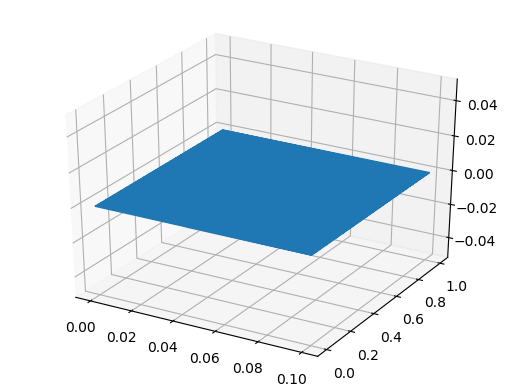

1-element Array{PyCall.PyObject,1}:
 PyObject <mpl_toolkits.mplot3d.art3d.Line3D object at 0x7fbfd0b04da0>

In [50]:
plot3D(var.r,var.z,var.v)
#triplot()

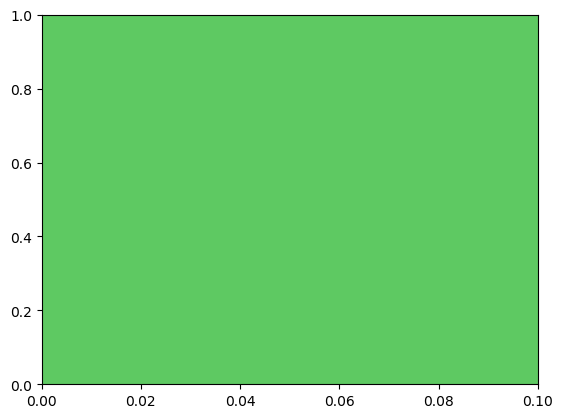

PyObject <matplotlib.tri.tricontour.TriContourSet object at 0x7fbfb46c0d68>

In [51]:
tricontourf(var.r,var.z,var.v)

In [53]:
? Const

search: Const const isconst MathConstants @colorant_str codeunits ncodeunits



No documentation found.

# Summary

```
struct Const <: Any
```

# Fields

```
Y0 :: Float64
ρ0 :: Float64
Γ0 :: Float64
μ  :: Float64
a0 :: Float64
s0 :: Float64
```


## 单位变换

$$ 1kg/m^3 = 10^{-3} g/cm^3$$
$$1m/s = 10^{-4} cm/\mu s$$
$$ 1Pa = 1N/m^2 = 1kg/(m\cdot s^2) = (1000g)/(100cm \cdot 10^{12} \mu s^2) = 10^{-11} g/(cm \cdot s^2)$$ 

In [163]:
 function Collapse()

    global problem = prb(1.3e2,0.1)
    # global problem = prb(5e-5,0.3)
    
    I = 20
    J = 16
    dr = 2.0/J
    dθ = 90/I
    
    I1 = I +2
    J1 = J
    
    global   con1 = Const(3.3e-3,1.845,2.0,1.519,1.287,1.124)
    
    Ip = (I1+1)*(J1+1) # Number of  points
    Ic = I1*J1  # number of cells
    
    global Tp = zeros(Int,Ic,4) #格点
    global Tc = zeros(Int,Ip,4) #点格
    
    #@show Tc, Ip
    global Tb = zeros(Int, I*2+J*2,3) #边界 
    
   # 点格表，格点表初始化 
    for i in 1:I 
        for j in 1:J
            ic = i+(j-1)*I
            Tp[ic,1] = i + (j-1)*(I+1)
            Tp[ic,2] = i+1 +(j-1)*(I+1)
            Tp[ic,3]=i+1+j*(I+1)
            Tp[ic,4]=i+j*(I+1) 
        end
    end
    
    for i = 1:I+1
        for j = 1:J+1
            ip = i+(j-1)*(I+1)
            Tc[ip,1] = i +(j-1)*I #(i,j)
            Tc[ip,2] = i-1+(j-1)*I #(i-1,j)
            Tc[ip,3] = i-1+(j-2)*I #(i-1,j-1)
            Tc[ip,4] = i+(j-2)*I   #(i,j-1)
            end
        end
    

  ib = 0
        for j = 1:J
           # if i == 1 || i== I ||  j == 1 || j == J
            for i in (1,I)
                ib += 1
                ic =i+(j-1)*I
                
                Tb[ib,1] = ic
                if i==1 
                    Tb[ib,2] = 4
                    Tb[ib,3] = 4
                    
                end   
                 if  i==I 
                    Tb[ib,2] = 2 #bound type 1:free 2: wall ..  Tb[:,2] y direction
                    Tb[ib,3] = 4
                end
                
    
            end
        end
      for i = 1:I
           # if i == 1 || i== I ||  j == 1 || j == J
            for j in (1,J)
                ib += 1
                ic =i+(j-1)*I
                
                Tb[ib,1] = ic
               
                if j==1 
                    Tb[ib,2] = 1
                    Tb[ib,3] = 1
                end
                if j==J
                    Tb[ib,2] = 3
                    Tb[ib,3] = 1
                end
            end
        end

    #流场初始化 Init of the flow
    
    x = zeros(Float64,Ip)
    y = zeros(Float64,Ip)
    u = zeros(Float64,Ip)
    v = zeros(Float64,Ip)
    
    ρ = zeros(Float64,Ic)
    mz = zeros(Float64,Ic)
    p = zeros(Float64,Ic)
    Az= zeros(Float64,Ic)
    s = zeros(Float64,Ic,3)
    
    for i in 1:I+1
        for j = 1:J+1
            ip =i+(j-1)*(I+1)
            r₁ = (j-1)*dr+8
            θ = 90-(i-1)*dθ
            v₀ = 4.171e-2
            x[ip] = cosd(θ)*r₁
            y[ip] = sind(θ)*r₁
            u[ip] = -v₀*8/r₁ *cosd(θ)
            v[ip] = -v₀*8/r₁ *sind(θ)
        end
    end
    
    xz = zeros(Float64,4)
    yz = zeros(Float64,4) 
    for i in 1:I
        for j in 1:J
            ic = i+(j-1)*I
            xz[1:4] = x[Tp[ic,1:4]]
            yz[1:4] = y[Tp[ic,1:4]]
            A = A_z(xz,yz)
            Az[ic] = sum(A) #[1]+A[2]+A[3]+A[4]
          #  if i>=I/2
               
                p[ic] = 1.e-5
                ρ[ic] = 1.845
                mz[ic] = ρ[ic] * Az[ic]
                s[ic,:] .= 0
                
#             else
#                 mz[ic] = 1.0 * Az[ic]
#                 p[ic] = 1.0
#                 ρ[ic] = 1.0
#             end
        end
    end
    var = Var(x,y,u,v,ρ,p,s)
    return var,mz,I,J
end

Collapse (generic function with 1 method)

In [ ]:
function Collapse()

    global problem = prb(1.3e2,0.1)
    # global problem = prb(5e-5,0.3)
    
    I = 20
    J = 16
    dr = 2.0/J
    dθ = 90/I
    
    I1 = I +2
    J1 = J
    
    global   con1 = Const(3.3e-3,1.845,2.0,1.519,1.287,1.124)
    
    Ip = (I1+1)*(J1+1) # Number of  points
    Ic = I1*J1  # number of cells
    
    global Tp = zeros(Int,Ic,4) #格点
    global Tc = zeros(Int,Ip,4) #点格
    
    #@show Tc, Ip
    global Tb = zeros(Int, I*2+J*2,3) #边界 
    
   # 点格表，格点表初始化 
    for i in 1:I 
        for j in 1:J
            ic = i+(j-1)*I
            Tp[ic,1] = i + (j-1)*(I+1)
            Tp[ic,2] = i+1 +(j-1)*(I+1)
            Tp[ic,3]=i+1+j*(I+1)
            Tp[ic,4]=i+j*(I+1) 
        end
    end
    
    for i = 1:I+1
        for j = 1:J+1
            ip = i+(j-1)*(I+1)
            Tc[ip,1] = i +(j-1)*I #(i,j)
            Tc[ip,2] = i-1+(j-1)*I #(i-1,j)
            Tc[ip,3] = i-1+(j-2)*I #(i-1,j-1)
            Tc[ip,4] = i+(j-2)*I   #(i,j-1)
            end
        end
    

  ib = 0
        for j = 1:J
           # if i == 1 || i== I ||  j == 1 || j == J
            for i in (1,I)
                ib += 1
                ic =i+(j-1)*I
                
                Tb[ib,1] = ic
                if i==1 
                    Tb[ib,2] = 4
                    Tb[ib,3] = 4
                    
                end   
                 if  i==I 
                    Tb[ib,2] = 2 #bound type 1:free 2: wall ..  Tb[:,2] y direction
                    Tb[ib,3] = 4
                end
                
    
            end
        end
      for i = 1:I
           # if i == 1 || i== I ||  j == 1 || j == J
            for j in (1,J)
                ib += 1
                ic =i+(j-1)*I
                
                Tb[ib,1] = ic
               
                if j==1 
                    Tb[ib,2] = 1
                    Tb[ib,3] = 1
                end
                if j==J
                    Tb[ib,2] = 3
                    Tb[ib,3] = 1
                end
            end
        end

    #流场初始化 Init of the flow
    
    x = zeros(Float64,Ip)
    y = zeros(Float64,Ip)
    u = zeros(Float64,Ip)
    v = zeros(Float64,Ip)
    
    ρ = zeros(Float64,Ic)
    mz = zeros(Float64,Ic)
    p = zeros(Float64,Ic)
    Az= zeros(Float64,Ic)
    s = zeros(Float64,Ic,3)
    
    for i in 1:I+1
        for j = 1:J+1
            ip =i+(j-1)*(I+1)
            r₁ = (j-1)*dr+8
            θ = 90-(i-1)*dθ
            v₀ = 4.171e-2
            x[ip] = cosd(θ)*r₁
            y[ip] = sind(θ)*r₁
            u[ip] = -v₀*8/r₁ *cosd(θ)
            v[ip] = -v₀*8/r₁ *sind(θ)
        end
    end
    
    xz = zeros(Float64,4)
    yz = zeros(Float64,4) 
    for i in 1:I
        for j in 1:J
            ic = i+(j-1)*I
            xz[1:4] = x[Tp[ic,1:4]]
            yz[1:4] = y[Tp[ic,1:4]]
            A = A_z(xz,yz)
            Az[ic] = sum(A) #[1]+A[2]+A[3]+A[4]
          #  if i>=I/2
               
                p[ic] = 1.e-5
                ρ[ic] = 1.845
                mz[ic] = ρ[ic] * Az[ic]
                s[ic,:] .= 0
                
#             else
#                 mz[ic] = 1.0 * Az[ic]
#                 p[ic] = 1.0
#                 ρ[ic] = 1.0
#             end
        end
    end
    var = Var(x,y,u,v,ρ,p,s)
    return var,mz,I,J
end

In [291]:
var,mz,I,J = Collapse()
var = TimeSolve(var,mz)
using DelimitedFiles
Output_cell(I,J,var,mz)

UndefVarError: UndefVarError: Collapse not defined

In [169]:
using DelimitedFiles
Output_cell(I,J,var,mz)

s = [-0.00171742 0.00175327 0.000189185; -0.00168295 0.00171887 0.000524381; -0.00160096 0.00163214 0.000795161; -0.00151875 0.00154046 0.00100198; -0.00139928 0.00142013 0.00120807; -0.00120652 0.00122241 0.00141616; -0.00102367 0.00104294 0.00154; -0.000818293 0.000844217 0.00161334; -0.00053414 0.000565869 0.0017055; -0.000175241 0.000211372 0.00174072; 0.000211372 -0.000175241 0.00174072; 0.000565869 -0.00053414 0.0017055; 0.000844217 -0.000818293 0.00161334; 0.00104294 -0.00102367 0.00154; 0.00122241 -0.00120652 0.00141616; 0.00142013 -0.00139928 0.00120807; 0.00154046 -0.00151875 0.00100198; 0.00163214 -0.00160096 0.000795161; 0.00171887 -0.00168295 0.000524381; 0.00175327 -0.00171742 0.000189185; -0.00168878 0.00172311 0.000182736; -0.00165575 0.00169537 0.000513659; -0.00157038 0.00160973 0.000770385; -0.00150563 0.00153602 0.000993481; -0.00140876 0.00142493 0.00123178; -0.00122739 0.00124042 0.00142449; -0.00101173 0.00104025 0.00152486; -0.000782412 0.000817108 0.00158676; -

In [137]:
tmp =0.0
for i in 1:41
   tmp += √(var.r[i]^2 + var.z[i]^2)
end
@show tmp/41

tmp / 41 = 4.995854782240405


4.995854782240405

In [138]:
tmax =0.0
for i in 1:41
    tmp2 = √(var.r[i]^2 + var.z[i]^2)
    if abs(tmp2 - tmp/41) >tmax
        tmax = abs(tmp2-tmp/41)
    end
end
@show tmax

tmax = 1.2724904090433142e-6


1.2724904090433142e-6

In [127]:
 rcell = zeros(Float64,4)
    zcell = zeros(Float64,4)
    ucell = zeros(Float64,4)
    vcell = zeros(Float64,4)

Ic, = size(Tp) 
for i in 1:Ic
        for j =1:4
            rcell[j] = var.r[Tp[i,j]]
            zcell[j] = var.z[Tp[i,j]]
            ucell[j] = var.u[Tp[i,j]]
            vcell[j] = var.v[Tp[i,j]]
        end
        Az = sum(A_z(rcell,zcell))
@show Az
end

Az = 1.6419662776071194e-6
Az = 1.6419678384125289e-6
Az = 1.6419698003352593e-6
Az = 1.6419715654210853e-6
Az = 1.6419731572467691e-6
Az = 1.641974608095325e-6
Az = 1.641975941807925e-6
Az = 1.6419771743152395e-6
Az = 1.6419783096624269e-6
Az = 1.6419793388436701e-6
Az = 1.6419802502085665e-6
Az = 1.6419810420707477e-6
Az = 1.6419817232254247e-6
Az = 1.6419823111354622e-6
Az = 1.6419828174849818e-6
Az = 1.6419832423586597e-6
Az = 1.6419835836882718e-6
Az = 1.6419838425131344e-6
Az = 1.6419840210321179e-6
Az = 1.6419841192303686e-6
Az = 1.6419841192313444e-6
Az = 1.6419840210315758e-6
Az = 1.6419838425136765e-6
Az = 1.6419835836878382e-6
Az = 1.6419832423583344e-6
Az = 1.6419828174855239e-6
Az = 1.6419823111348117e-6
Az = 1.6419817232245573e-6
Az = 1.641981042071073e-6
Az = 1.6419802502072112e-6
Az = 1.6419793388439412e-6
Az = 1.6419783096627521e-6
Az = 1.6419771743149143e-6
Az = 1.6419759418077082e-6
Az = 1.641974608094783e-6
Az = 1.641973157246471e-6
Az = 1.6419715654211666e-6
Az = 1

Az = 1.7567941432873732e-6
Az = 1.756793928400671e-6
Az = 1.7567936446464226e-6
Az = 1.7567932968799022e-6
Az = 1.756792884058324e-6
Az = 1.7567924085086029e-6
Az = 1.7567918687585006e-6
Az = 1.7567912605787614e-6
Az = 1.7567905901741659e-6
Az = 1.7567898498652016e-6
Az = 1.7567890116599368e-6
Az = 1.7567880575337816e-6
Az = 1.7567869878253864e-6
Az = 1.7567858017142812e-6
Az = 1.7567844938249917e-6
Az = 1.756783051287252e-6
Az = 1.756781450354785e-6
Az = 1.7567819602281446e-6
Az = 1.7695408725087439e-6
Az = 1.7695403904759952e-6
Az = 1.76954196055257e-6
Az = 1.7695433768795865e-6
Az = 1.7695446653991976e-6
Az = 1.7695458344792756e-6
Az = 1.769546879797784e-6
Az = 1.769547800027822e-6
Az = 1.7695486110131612e-6
Az = 1.7695493353725358e-6
Az = 1.769549993384592e-6
Az = 1.769550591082373e-6
Az = 1.7695511222856012e-6
Az = 1.769551590883418e-6
Az = 1.7695519987684068e-6
Az = 1.7695523428805154e-6
Az = 1.769552621395899e-6
Az = 1.7695528358592201e-6
Az = 1.7695529823129243e-6
Az = 1.769553

Az = 1.8843888401810392e-6
Az = 1.8843896058964383e-6
Az = 1.8843903114868638e-6
Az = 1.8843909530873518e-6
Az = 1.8843915457129098e-6
Az = 1.8843920904692071e-6
Az = 1.8843925825048728e-6
Az = 1.8843930223913898e-6
Az = 1.8843934058201386e-6
Az = 1.8843937322321046e-6
Az = 1.8843939977137517e-6
Az = 1.884394199664621e-6
Az = 1.8843943395548905e-6
Az = 1.8843944124050365e-6
Az = 1.8843944124059039e-6
Az = 1.8843943395559747e-6
Az = 1.8843941996650546e-6
Az = 1.8843939977141854e-6
Az = 1.884393732231671e-6
Az = 1.8843934058216565e-6
Az = 1.8843930223895466e-6
Az = 1.884392582504656e-6
Az = 1.8843920904703998e-6
Az = 1.884391545711934e-6
Az = 1.8843909530870265e-6
Az = 1.8843903114868638e-6
Az = 1.8843896058962214e-6
Az = 1.8843888401802802e-6
Az = 1.8843880069342104e-6
Az = 1.8843870505582273e-6
Az = 1.8843859196018419e-6
Az = 1.884384624834597e-6
Az = 1.8843831992549042e-6
Az = 1.8843834061914975e-6
Az = 1.8971448618677599e-6
Az = 1.8971446855903847e-6
Az = 1.8971461045137403e-6
Az = 1

Az = 1.999249111229724e-6
Az = 1.999248353616351e-6
Az = 1.999247531118682e-6
Az = 1.9992466252583344e-6
Az = 1.9992456229936026e-6
Az = 1.999244540038127e-6
Az = 1.999243266240938e-6
Az = 1.9992431023590023e-6
Az = 2.0120060379959364e-6
Az = 2.012006322057075e-6
Az = 2.012007546154152e-6
Az = 2.012008624903113e-6
Az = 2.0120096274287035e-6
Az = 2.0120105288005084e-6
Az = 2.0120113622665086e-6
Az = 2.0120121193359375e-6
Az = 2.0120128173454046e-6
Az = 2.0120134621516616e-6
Az = 2.0120140619405433e-6
Az = 2.0120146157860327e-6
Az = 2.0120151181563135e-6
Az = 2.01201556766133e-6
Az = 2.012015964059956e-6
Az = 2.012016303147004e-6
Az = 2.0120165776531165e-6
Az = 2.012016788450208e-6
Az = 2.0120169328631185e-6
Az = 2.0120170075316884e-6
Az = 2.0120170075299537e-6
Az = 2.012016932863769e-6
Az = 2.01201678844869e-6
Az = 2.0120165776542007e-6
Az = 2.012016303146137e-6
Az = 2.0120159640606063e-6
Az = 2.0120155676604627e-6
Az = 2.0120151181552293e-6
Az = 2.0120146157851654e-6
Az = 2.01201406194

In [3]:
 function Impact()

    global problem = prb(6000,0.1)
    # global problem = prb(5e-5,0.3)
    
    I = 50
    J = 10
    dx = 500/I
    dy = 100/J
    
    global   con1 = Const(0.0,2.785,2.0,2.7e-1,0.5328,1.338)
    
    Ip = (I+1)*(J+1) # Number of  points
    Ic = I*J  # number of cells
    
    global Tp = zeros(Int,Ic,4) #格点
    global Tc = zeros(Int,Ip,4) #点格
    
    #@show Tc, Ip
    global Tb = zeros(Int, I*2+J*2,3) #边界 
    
    
   # 点格表，格点表初始化 
    for i in 1:I 
        for j in 1:J
            ic = i+(j-1)*I
            Tp[ic,1] = i + (j-1)*(I+1)
            Tp[ic,2] = i+1 +(j-1)*(I+1)
            Tp[ic,3]=i+1+j*(I+1)
            Tp[ic,4]=i+j*(I+1) 
        end
    end
    
    for i = 1:I+1
        for j = 1:J+1
            ip = i+(j-1)*(I+1)
            Tc[ip,1] = i +(j-1)*I #(i,j)
            Tc[ip,2] = i-1+(j-1)*I #(i-1,j)
            Tc[ip,3] = i-1+(j-2)*I #(i-1,j-1)
            Tc[ip,4] = i+(j-2)*I   #(i,j-1)
            end
        end
    

  ib = 0
        for j = 1:J
           # if i == 1 || i== I ||  j == 1 || j == J
            for i in (1,I)
                ib += 1
                ic =i+(j-1)*I
                
                Tb[ib,1] = ic
                if i==1 
                    Tb[ib,2] = 4
                    Tb[ib,3] = 4
                    
                end   
                 if  i==I 
                    Tb[ib,2] = 2 #bound type 1:free 2: wall ..  Tb[:,2] y direction
                    Tb[ib,3] = 1
                end
                
    
            end
        end
      for i = 1:I
           # if i == 1 || i== I ||  j == 1 || j == J
            for j in (1,J)
                ib += 1
                ic =i+(j-1)*I
                
                Tb[ib,1] = ic
               
                if j==1 
                    Tb[ib,2] = 1
                    Tb[ib,3] = 1
                end
                if j==J
                    Tb[ib,2] = 3
                    Tb[ib,3] = 1
                end
            end
        end

    #流场初始化 Init of the flow
    
    x = zeros(Float64,Ip)
    y = zeros(Float64,Ip)
    u = zeros(Float64,Ip)
    v = zeros(Float64,Ip)
    
    ρ = zeros(Float64,Ic)
    mz = zeros(Float64,Ic)
    p = zeros(Float64,Ic)
    Az= zeros(Float64,Ic)
    s = zeros(Float64,Ic,3)
    
    ϵ = 1/2*dy
    for i in 1:I+1
        for j = 1:J+1
            ip =i+(j-1)*(I+1)
           
            x[ip] = (i-1)*dx
            y[ip] = (j-1)*dy
            u[ip] = -1.50e-2
            v[ip] = 0.0
        end
    end
    
    xz = zeros(Float64,4)
    yz = zeros(Float64,4) 
    for i in 1:I
        for j in 1:J
            ic = i+(j-1)*I
            xz[1:4] = x[Tp[ic,1:4]]
            yz[1:4] = y[Tp[ic,1:4]]
            A = A_z(xz,yz)
            Az[ic] = sum(A) #[1]+A[2]+A[3]+A[4]
          #  if i>=I/2
               
                p[ic] = 0.0
                ρ[ic] = 2.785
                mz[ic] = ρ[ic] * Az[ic]
                s[ic,:] .= 0
        end
    end
    var = Var(x,y,u,v,ρ,p,s)
    return var,mz,I,J
end

Impact (generic function with 1 method)

In [4]:
var,mz,I,J = Impact()
var = TimeSolve(var,mz)

using DelimitedFiles
Output_cell(I,J,var,mz)

UndefVarError: UndefVarError: prb not defined

In [100]:
using DelimitedFiles
Output_point(I,J,var,mz)